# **Southeast Asia GeoGuessr**

## **FEASIBILITY**

**Installing Packages and Data**

In [26]:
import os
import numpy as np
import keras
from keras import layers
from keras import models
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
import random
from keras.utils import load_img, img_to_array
import pandas as pd

**Load in Training and Testing Data**

In [2]:
dataset_path = r"C:\Users\Marielle\OneDrive\Desktop\SEAGeo"
image_size = (224, 224)
batch_size = 32
validation_split = 0.2
seed = 1337

# Load training dataset (80% of data)
train_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

# Load validation dataset (20% of data)
val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

# Check class names (should be the 4 folders)
print("Classes:", train_ds.class_names)

Found 3573 files belonging to 4 classes.
Using 2859 files for training.
Found 3573 files belonging to 4 classes.
Using 714 files for validation.
Classes: ['Indonesia', 'Malaysia', 'Philippines', 'Thailand']


**See What It Looks Like**

Classes: ['Indonesia', 'Malaysia', 'Philippines', 'Thailand']


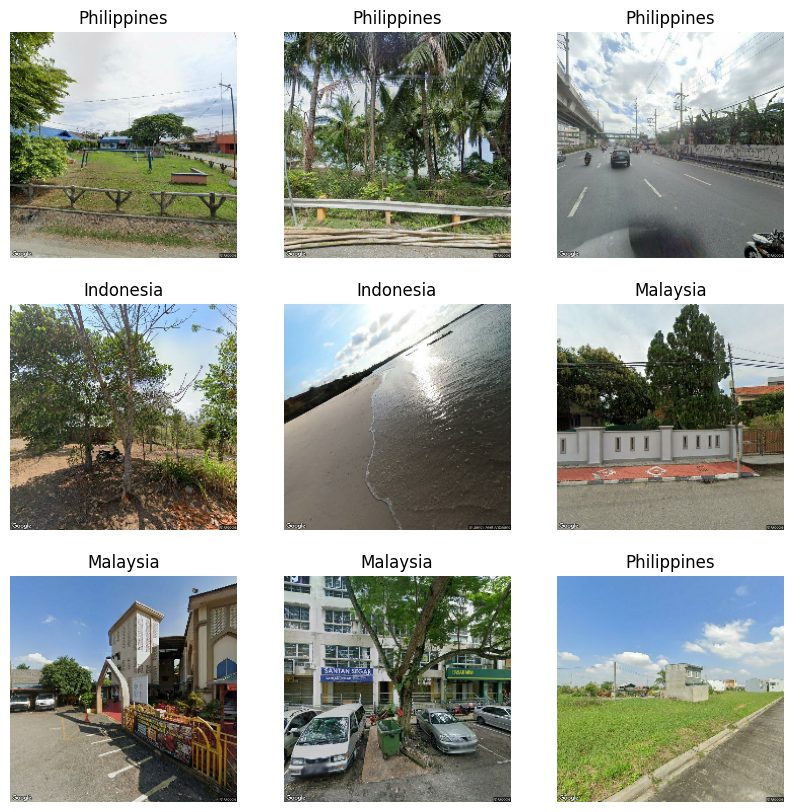

In [3]:
class_names = train_ds.class_names
print("Classes:", class_names)

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  # take one batch
    for i in range(9):  # first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        
        # Use class_names to get the actual class label string
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

plt.show()

**Normalizing and Augmenting Training Images**

In [4]:
# Normalize function (scale pixels 0-1) and applying it
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

In [5]:
# Data augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

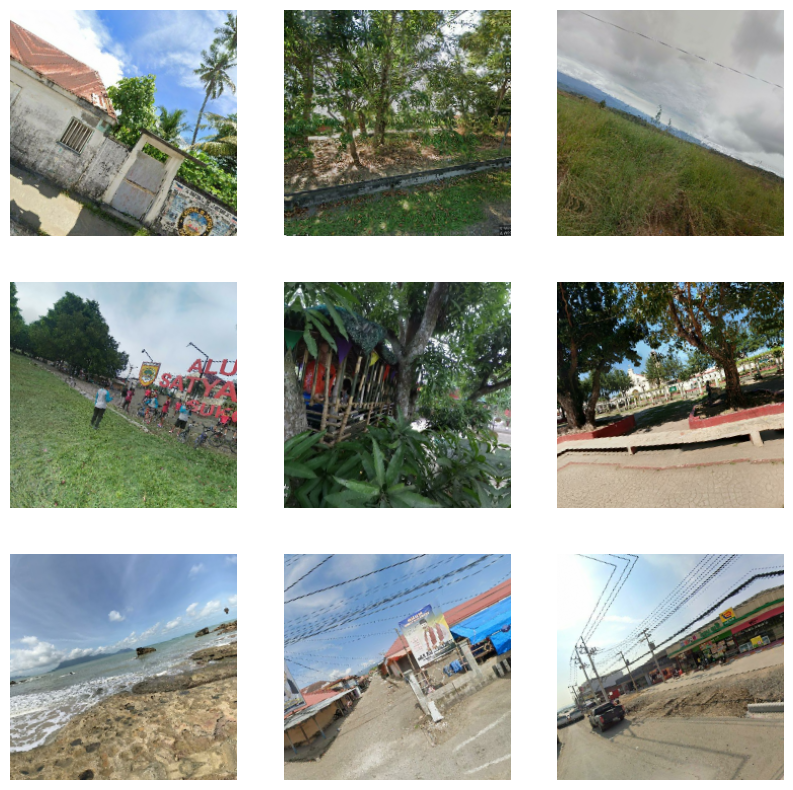

In [6]:
# Visualize image augmentations 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy())
        plt.axis("off")
plt.show()

In [7]:
# Applying augmentation to training set only
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetch for performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## **MODEL TRAINING AND PROTOTYPE**

### **Custom Model from Scratch**

**Building and Training the Model**

In [48]:
def build_custom_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        # Normalize input (already done in dataset but still safe here)
        layers.Rescaling(1./255),

        # Convolutional layers
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')  # softmax for multi-class
    ])

    return model

In [49]:
# Compile the model
custom_model = build_custom_model(input_shape=image_size + (3,), num_classes=4)

custom_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [50]:
# Set callbacks
early_stop_custom = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_custom = ModelCheckpoint("custom_cnn_model.keras", save_best_only=True)

In [51]:
# Train the model
history_custom = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop_custom, checkpoint_custom]
)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - accuracy: 0.2256 - loss: 1.3894 - val_accuracy: 0.2465 - val_loss: 1.3863
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.2512 - loss: 1.3864 - val_accuracy: 0.2507 - val_loss: 1.3863
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.2402 - loss: 1.3864 - val_accuracy: 0.2465 - val_loss: 1.3864
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.2595 - loss: 1.3864 - val_accuracy: 0.2507 - val_loss: 1.3864
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.2617 - loss: 1.3864 - val_accuracy: 0.2507 - val_loss: 1.3864
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.2597 - loss: 1.3864 - val_accuracy: 0.2507 - val_loss: 1.3864


**Evaluating the Model**

In [52]:
custom_val_loss, custom_val_accuracy = custom_model.evaluate(val_ds)
print(f"Validation Loss: {custom_val_loss:.4f}")
print(f"Validation Accuracy: {custom_val_accuracy:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.2535 - loss: 1.3864
Validation Loss: 1.3863
Validation Accuracy: 0.2465


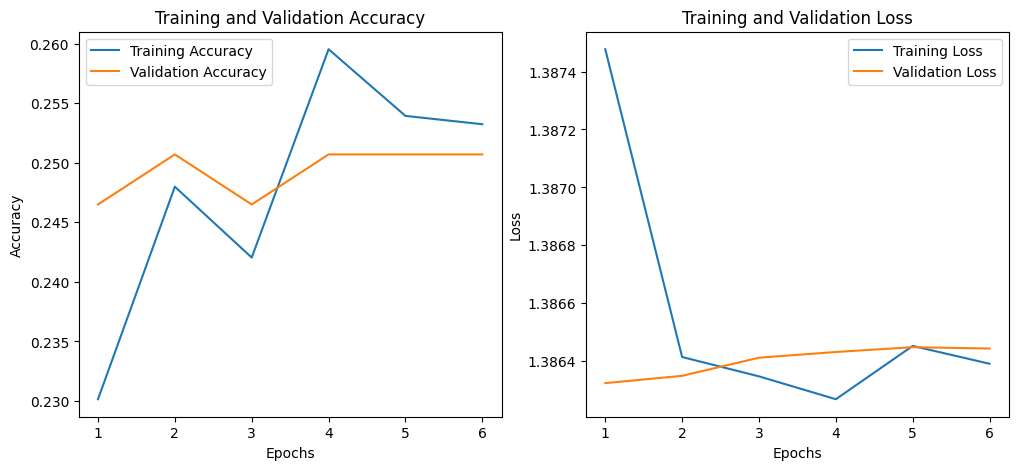

In [53]:
acc = history_custom.history['accuracy']
val_acc = history_custom.history['val_accuracy']
loss = history_custom.history['loss']
val_loss = history_custom.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Test Prediction on Some Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


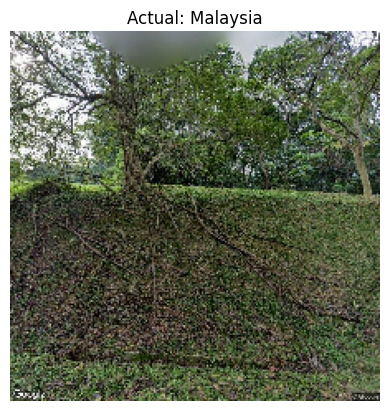

The model predicts Malaysia with 27.21% confidence.
Correct!


In [54]:
# Random image prediction and display
class_names = sorted(os.listdir(dataset_dir))

chosen_class = random.choice(class_names)
class_dir = os.path.join(dataset_dir, chosen_class)
chosen_image = random.choice(os.listdir(class_dir))
image_path = os.path.join(class_dir, chosen_image)

img = load_img(image_path, target_size=image_size)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

predictions = model.predict(img_array)
predicted_index = np.argmax(predictions)
predicted_class = class_names[predicted_index]
confidence = tf.nn.softmax(predictions)[0][predicted_index] * 100

plt.imshow(img)
plt.axis("off")
plt.title(f"Actual: {chosen_class}")
plt.show()

print(f"The model predicts {predicted_class} with {confidence:.2f}% confidence.")
print("Correct!" if predicted_class == chosen_class else "Incorrect.")

**Save Custom Model**

In [56]:
model.save("custom_cnn_model.keras")

### **Transfer Learning with MobileNet**

In [8]:
from keras.applications import MobileNetV2
from keras import layers, models, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

**Building and Training the Model**

In [9]:
# Load MobileNetV2 base model (pretrained on ImageNet)
base_model = MobileNetV2(
    input_shape=image_size + (3,),  # your image size + 3 color channels
    include_top=False,              # exclude the original classifier head
    weights="imagenet"              # use pretrained ImageNet weights
)
base_model.trainable = False  # freeze base for transfer learning


In [10]:
# Build your custom classifier on top
inputs = layers.Input(shape=image_size + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

num_classes = 4  # Philippines, Thailand, Malaysia, Indonesia

if num_classes == 2:
    outputs = layers.Dense(1, activation='sigmoid')(x)
else:
    outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [11]:
# Compile the model
if num_classes == 2:
    loss = 'binary_crossentropy'
else:
    loss = 'sparse_categorical_crossentropy'  # assuming labels are integer encoded

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=loss,
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenet_best_model.keras', save_best_only=True)

In [13]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - accuracy: 0.2571 - loss: 1.7578 - val_accuracy: 0.2871 - val_loss: 1.5071
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.2496 - loss: 1.6790 - val_accuracy: 0.2815 - val_loss: 1.4815
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - accuracy: 0.2944 - loss: 1.5890 - val_accuracy: 0.2969 - val_loss: 1.4659
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.2855 - loss: 1.5868 - val_accuracy: 0.2969 - val_loss: 1.4453
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.2918 - loss: 1.5277 - val_accuracy: 0.3207 - val_loss: 1.4378
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.2815 - loss: 1.5561 - val_accuracy: 0.3305 - val_loss: 1.4288
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.2932 - loss: 1.5225 - val_accuracy: 0.3165 - val_loss: 1.4187
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.2942 - loss: 1.4967 - val_accu

**Evaluating the Model**

In [14]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.3052 - loss: 1.3915
Validation Loss: 1.3649
Validation Accuracy: 0.3375


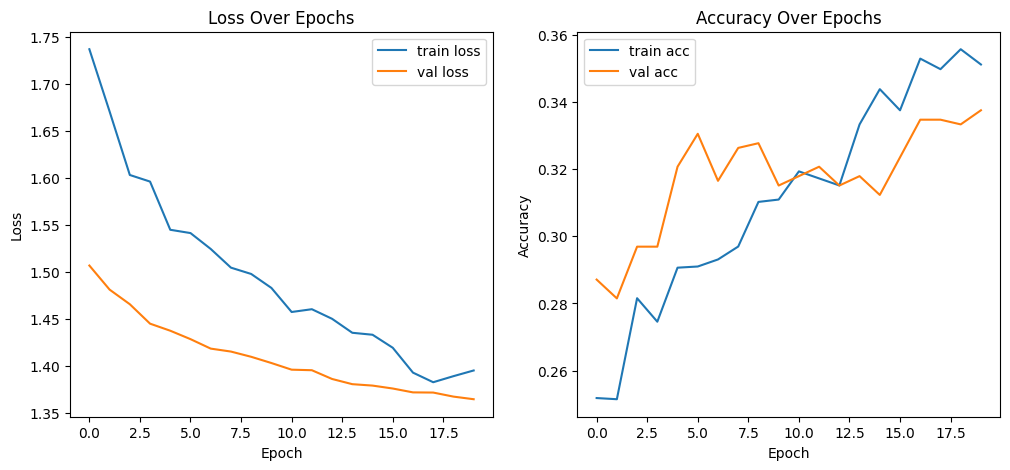

In [15]:
history = history

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Test Prediction on Some Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


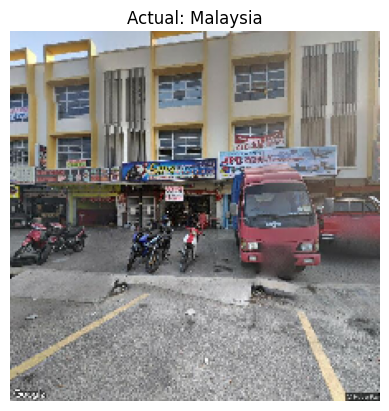

The model predicts Philippines with 35.80% confidence.

Incorrect.


In [16]:
# Set up directory and class names
dataset_dir = r"C:\Users\Marielle\OneDrive\Desktop\SEAGeo"  # Your base path
class_names = sorted(os.listdir(dataset_dir))  # ['Indonesia', 'Malaysia', 'Philippines', 'Thailand']

# Randomly pick a country and image
chosen_class = random.choice(class_names)
chosen_class_path = os.path.join(dataset_dir, chosen_class)
image_file = random.choice(os.listdir(chosen_class_path))
img_path = os.path.join(chosen_class_path, image_file)

# Load and preprocess image
img = image.load_img(img_path, target_size=image_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

# Predict
predictions = model.predict(img_array)
predicted_index = np.argmax(predictions)
predicted_class = class_names[predicted_index]
confidence = predictions[0][predicted_index] * 100

# Display result
plt.imshow(img)  # This line works with PIL Images
plt.axis("off")
plt.title(f"Actual: {chosen_class}")
plt.show()

print(f"The model predicts {predicted_class} with {confidence:.2f}% confidence.")
if predicted_class == chosen_class:
    print("\nCorrect!")
else:
    print("\nIncorrect.")

**Save MobileNet Model**

In [35]:
model.save("mobilenet_final_model.keras")

### **Transfer Learning with ResNet**

In [36]:
from keras.applications import ResNet50

**Building and Training the Model**

In [37]:
# Create the ResNet model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=image_size + (3,)
)
base_model.trainable = False  # Freeze base

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [38]:
# Build the model

resnet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # assuming categorical classification
])

In [39]:
# Compile the model

resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet_best_model.keras', save_best_only=True)


In [41]:
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 565ms/step - accuracy: 0.2398 - loss: 1.6077 - val_accuracy: 0.2507 - val_loss: 1.3989
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 535ms/step - accuracy: 0.2413 - loss: 1.4341 - val_accuracy: 0.2465 - val_loss: 1.3923
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 528ms/step - accuracy: 0.2605 - loss: 1.4194 - val_accuracy: 0.2535 - val_loss: 1.3864
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 527ms/step - accuracy: 0.2571 - loss: 1.4120 - val_accuracy: 0.2647 - val_loss: 1.3972
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 522ms/step - accuracy: 0.2706 - loss: 1.4035 - val_accuracy: 0.2633 - val_loss: 1.3982
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 522ms/step - accuracy: 0.2553 - loss: 1.4079 - val_accuracy: 0.2591 - val_loss: 1.4003
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 530ms/step - accuracy: 0.2611 - loss: 1.4071 - val_accuracy: 0.2633 - val_loss: 1.3966
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 528ms/step - accuracy: 0.2515 - loss: 1.3940 - val_accu

**Evaluating the Model**

In [42]:
rn_val_loss, rn_val_accuracy = resnet_model.evaluate(val_ds)
print(f"Validation Loss: {rn_val_loss:.4f}")
print(f"Validation Accuracy: {rn_val_accuracy:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - accuracy: 0.3081 - loss: 1.3784
Validation Loss: 1.3810
Validation Accuracy: 0.2927


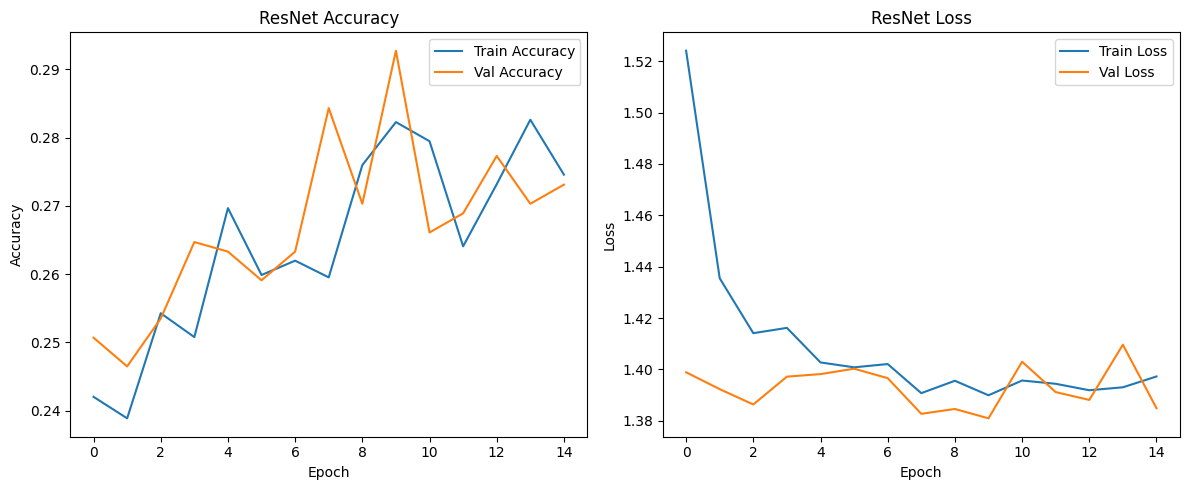

In [43]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title('ResNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Test Prediction on Some Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


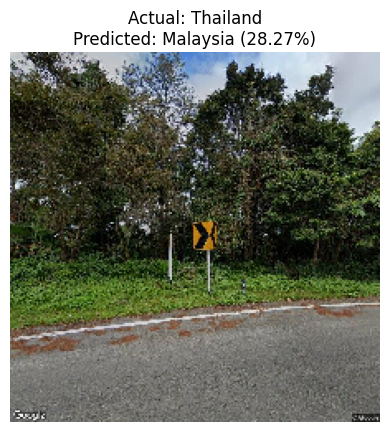

The model predicts **Malaysia** with **28.27%** confidence.

Incorrect.


In [46]:
# Set base path and class names
dataset_dir = r"C:\Users\Marielle\OneDrive\Desktop\SEAGeo"
class_names = sorted(os.listdir(dataset_dir))  # Ensure order is consistent

# Pick a random image
chosen_class = random.choice(class_names)
chosen_path = os.path.join(dataset_dir, chosen_class)
image_file = random.choice(os.listdir(chosen_path))
img_path = os.path.join(chosen_path, image_file)

# Load and preprocess image
img = load_img(img_path, target_size=image_size)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

# Predict using the ResNet model
predictions = resnet_model.predict(img_array)
predicted_index = np.argmax(predictions)
predicted_class = class_names[predicted_index]
confidence = predictions[0][predicted_index] * 100

# Display image and prediction
plt.imshow(img)
plt.axis("off")
plt.title(f"Actual: {chosen_class}\nPredicted: {predicted_class} ({confidence:.2f}%)")
plt.show()

# Print result
print(f"The model predicts {predicted_class} with {confidence:.2f}% confidence.")
if predicted_class == chosen_class:
    print("\nCorrect!")
else:
    print("\nIncorrect.")

**Save ResNet Model**

In [47]:
resnet_model.save("resnet_model.keras")

## **CONCLUSIONS**

### **Interpretations and Evaluations for Each Model**

**Custom Model**

- Validation Accuracy: 24.65%
- Validation Loss: 1.3863
- Early Stopping: Triggered at epoch 6 due to no improvement
- Training Accuracy: Increased but unstable
- Training Loss: Decreasing but spiky
- Validation Accuracy & Loss: Flat or worsening

Custom model isn't performing s0 well. The accuracy is around 25%, which is about the same as random guessing for 4 classes. The validation accuracy stayed flat, and validation loss increased, meaning the model didn’t learn meaningful patterns. The training accuracy fluctuated a lot, suggesting instability. Overall, the model likely underfit and may not be deep or expressive enough. 

**MobileNet**

- Validation Accuracy: 33.75% (better than the custom model but still low)
- Validation Loss: 1.3649
- Training Accuracy Curve: Slopes downward smoothly overall, but has bumps, indicating steady but imperfect learning.
- Validation Accuracy Curve: Also slopes downward, suggesting improvement, but still not great.
- Training Loss Curve: Starts low (good), but increases, which is a sign of potential overfitting or unstable learning.
- Validation Loss Curve: Gradually increases, with a log-like shape, indicating the model is starting to overfit.

MobileNet learned better than the custom model, but still struggled to generalize well. The increasing validation loss despite improved accuracy suggests it's overfitting slightly or learning some spurious patterns. The bumps and fluctuations show it's trying to improve, but may need regularization, more data, or augmentation tweaks.

**ResNet**

- Validation Accuracy: 29.3% (Higher than the custom model, but slightly lower than MobileNet)
- Validation Loss: 1.3810 (Slightly better (lower) than MobileNet and custom model)
- Epochs Completed: 15 out of 20. Early stopping triggered (a good sign, meaning no overtraining)
- Accuracy:
    - Training and validation both show large, sharp spikes, suggesting the model was learning but inconsistently. Both curves trend upward in a logarithmic fashion, showing slow, steady improvement. The fact that training and validation end at similar accuracy is a good sign of no major overfitting.
- Loss:
    - Training loss dips like a slide but has wide fluctuations — the model is struggling to stabilize. Validation loss hovers with spikes, meaning it’s not worsening, but also not improving reliably.

ResNet seems to have better generalization than the custom model, but slightly underperforms MobileNet in raw accuracy. However, it didn’t overfit, and the fact that both training and validation accuracy were close might suggest it's more stable than MobileNet overall. But learning was a bit noisy.

**Model Comparison**

| Model         | Validation Accuracy | Validation Loss | Stability | Overfitting Signs | Epochs |
| ------------- | ------------------- | --------------- | --------- | ----------------- | ------ |
| **Custom**    | **24.6%**           | 1.3863          | Poor      | Early overfit     | 6/20   |
| **MobileNet** | **33.75%**          | 1.3649          | Good      | Gradual overfit   | 20/20  |
| **ResNet**    | **29.3%**           | 1.3810          | Unstable  | High fluctuations | 15/20  |


### **From our results, our best model was MobileNet**

This is because it had the highest validation accuracy (32.4%), most consistent and smooth training curves, completed all epochs, showing more stable learning. And although validation loss rose slightly, it remained less erratic than ResNet’s.

**Deployed Model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


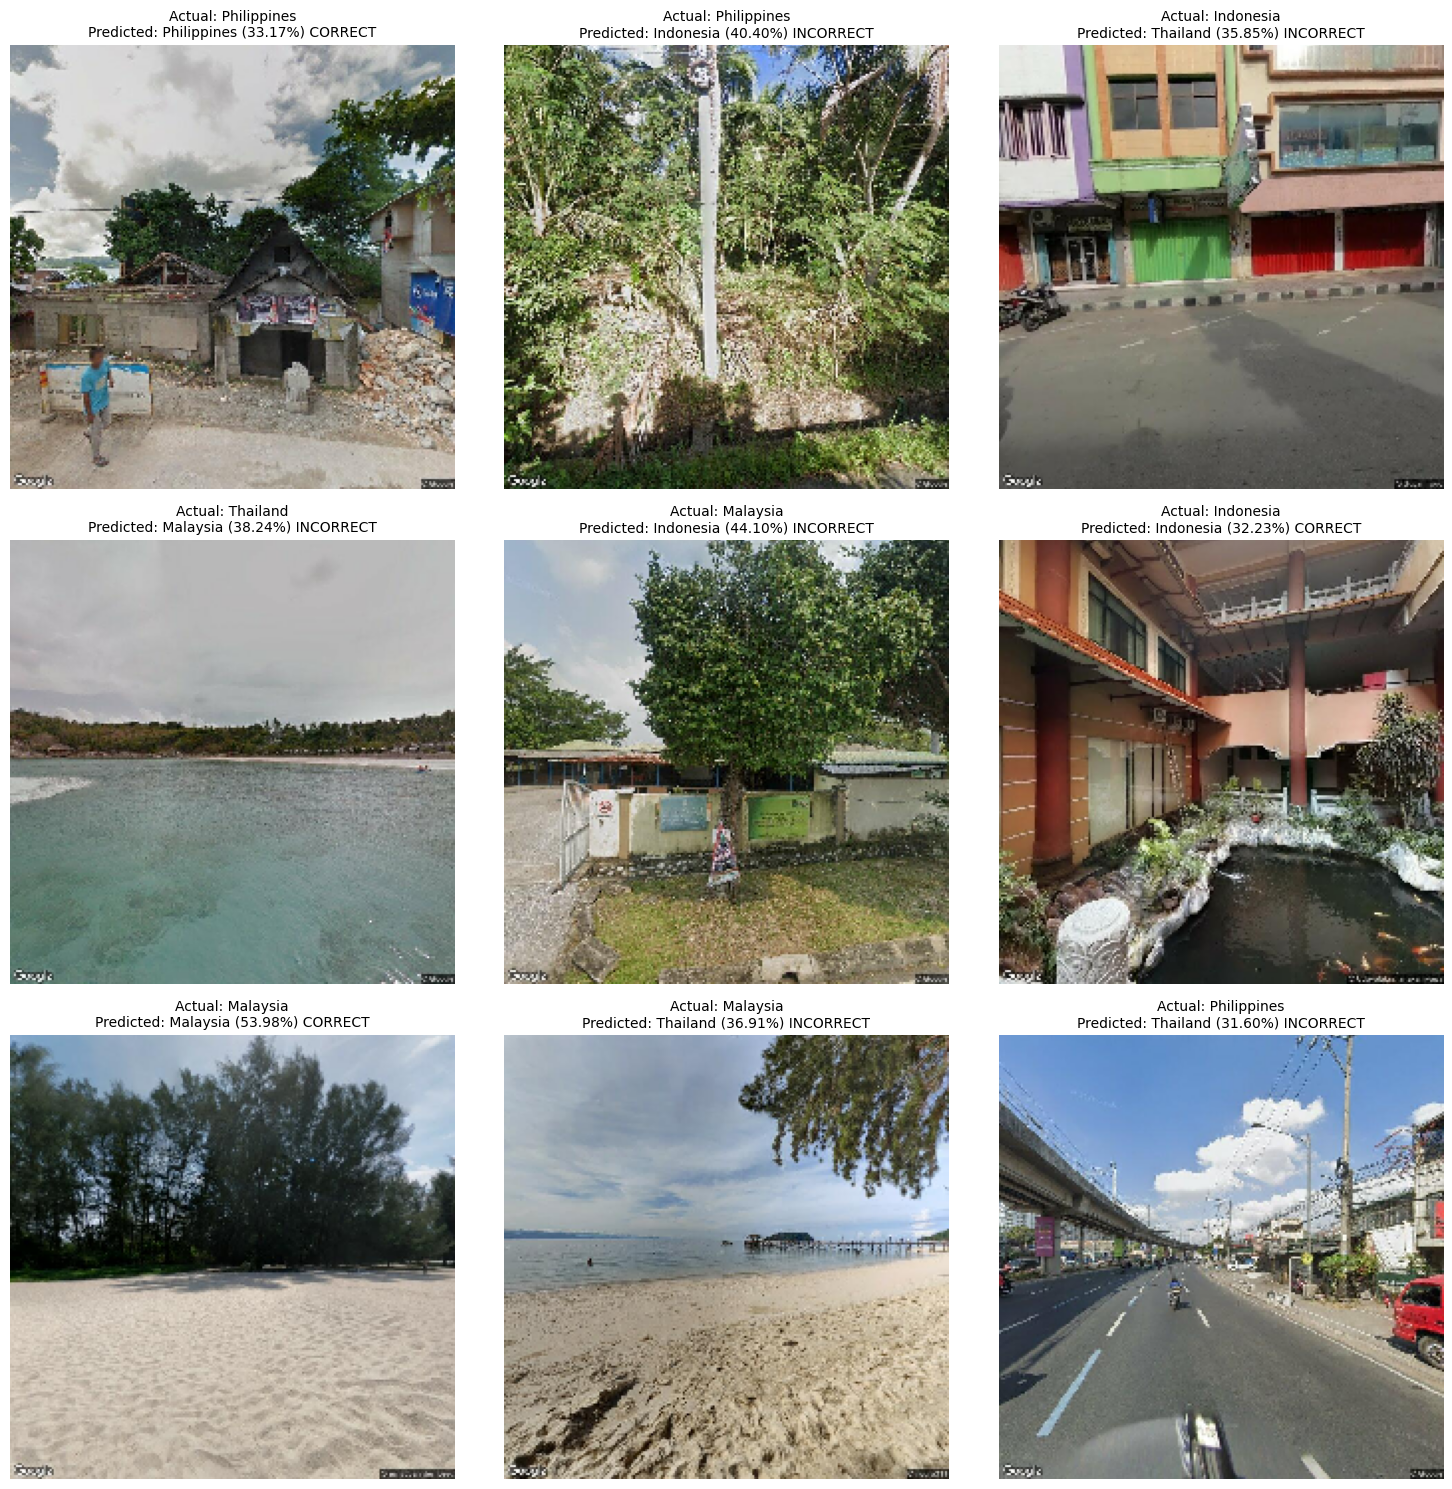

In [19]:
dataset_dir = r"C:\Users\Marielle\OneDrive\Desktop\SEAGeo"
class_names = sorted(os.listdir(dataset_dir))  # ['Indonesia', 'Malaysia', 'Philippines', 'Thailand']

plt.figure(figsize=(15, 15))  # 3x3 grid

# Loop for 9 images
for i in range(9):
    # Randomly pick class and image
    chosen_class = random.choice(class_names)
    chosen_class_path = os.path.join(dataset_dir, chosen_class)
    image_file = random.choice(os.listdir(chosen_class_path))
    img_path = os.path.join(chosen_class_path, image_file)

    # Load and preprocess
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_class = class_names[predicted_index]
    confidence = predictions[0][predicted_index] * 100

    # Display
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

    # Annotate with prediction info
    result = "CORRECT" if predicted_class == chosen_class else "INCORRECT"
    title_text = (
        f"Actual: {chosen_class}\n"
        f"Predicted: {predicted_class} ({confidence:.2f}%) {result}"
    )
    ax.set_title(title_text, fontsize=10)

plt.tight_layout()
plt.show()

**Model Accuracy Based on Each Country**

In [20]:
from keras.utils import load_img, img_to_array

In [ ]:
dataset_dir = r"C:\Users\Marielle\OneDrive\Desktop\SEAGeo"
class_names = sorted(os.listdir(dataset_dir))

results = []

for country in class_names:
    country_path = os.path.join(dataset_dir, country)
    image_files = os.listdir(country_path)
    correct = 0
    total = len(image_files)
    
    for img_file in image_files:
        img_path = os.path.join(country_path, img_file)
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        preds = model.predict(img_array, verbose=0)
        pred_idx = np.argmax(preds)
        pred_country = class_names[pred_idx]
        
        if pred_country == country:
            correct += 1
    
    accuracy = correct / total * 100
    results.append({'Country': country, 'Accuracy': accuracy, 'Total Images': total})

df_results = pd.DataFrame(results)

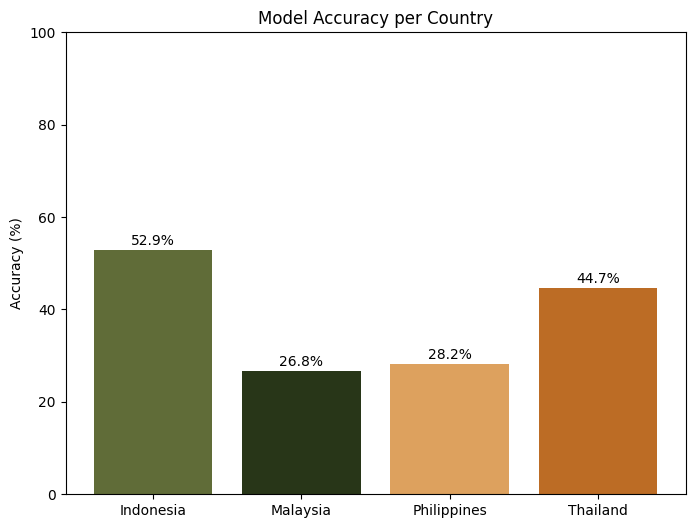

In [29]:
# Plot
country_colors = {
    'Indonesia': '#606c38',     
    'Malaysia': '#283618',      
    'Philippines': '#dda15e',   
    'Thailand': '#bc6c25'}

# Map each bar to its color
colors = [country_colors[country] for country in df_results['Country']]

# Plot
plt.figure(figsize=(8,6))
bars = plt.bar(df_results['Country'], df_results['Accuracy'], color=colors)
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy per Country')

# Annotate each bar
for i, v in enumerate(df_results['Accuracy']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.show()

In [45]:
df_results['Correct'] = (df_results['Accuracy'] / 100 * df_results['Total Images']).round().astype(int)
df_results['Incorrect'] = df_results['Total Images'] - df_results['Correct']

df_results

Country   Accuracy  Total Images  Correct  Incorrect
0    Indonesia  52.934537           886      469        417
1     Malaysia  26.763718           893      239        654
2  Philippines  28.236607           896      253        643
3     Thailand  44.654788           898      401        497

**Confidence of Model**

- Grouping by Predicted country = Self-Assessed certainty
    - "For all images the model predicted as country X, how confident was it on average?"
- Grouping by Actual country = HOW THE MODEL **FEELS** when it sees a country
    - "For all images truly from country X, how confident is the model when predicting them (right or wrong)?"

In [31]:
# Initialize
predictions_data = []

for country in class_names:
    country_path = os.path.join(dataset_dir, country)
    image_files = os.listdir(country_path)
    
    for img_file in image_files:
        img_path = os.path.join(country_path, img_file)
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        preds = model.predict(img_array, verbose=0)
        pred_idx = np.argmax(preds)
        pred_country = class_names[pred_idx]
        confidence = preds[0][pred_idx] * 100
        
        predictions_data.append({
            'Actual': country,
            'Predicted': pred_country,
            'Confidence': confidence
        })

# Create dataframe
df_predictions = pd.DataFrame(predictions_data)

In [35]:
# Overall confidence of model
# Answers the question: How confident is the model when making its answer, regardless if it was wrong or right.

overall_conf = df_predictions['Confidence'].mean()
print(f"Overall average confidence of model: {overall_conf:.2f}%")

Overall average confidence of model: 41.40%


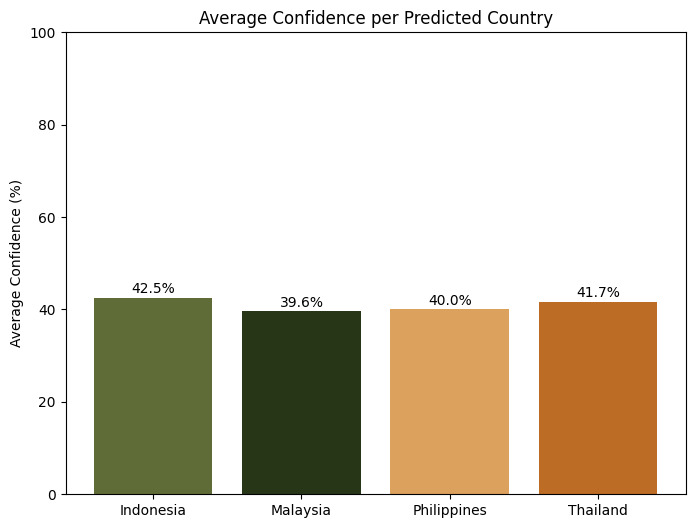

In [40]:
# Overall confidence of model per country, predicted
# Answers the question: How confident am I that this country is ___ when shown an image?

country_colors = {
    'Indonesia': '#606c38',     
    'Malaysia': '#283618',      
    'Philippines': '#dda15e',   
    'Thailand': '#bc6c25'}

# Group by predicted country and get average confidence
country_conf = df_predictions.groupby('Predicted')['Confidence'].mean().reset_index()
country_conf.columns = ['Country', 'AvgConfidence']

# Plot
plt.figure(figsize=(8,6))
bars = plt.bar(
    country_conf['Country'],
    country_conf['AvgConfidence'],
    color=[country_colors[c] for c in country_conf['Country']]
)
plt.ylim(0, 100)
plt.ylabel('Average Confidence (%)')
plt.title('Average Confidence per Predicted Country')

# Add confidence values on top of each bar
for i, v in enumerate(country_conf['AvgConfidence']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.show()

- Whenever the model predicts Indonesia, it’s on average 42.5% confident in that guess.
- Whenever it predicts Malaysia, it’s 39.6% confident on average.
- Philippines guesses have 40% average confidence.
- Thailand guesses have 41.7% average confidence.

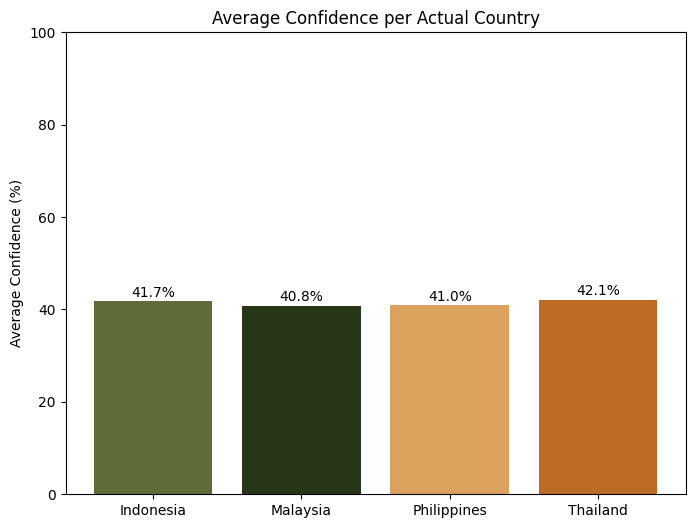

In [42]:
# Overall confidence of model per country, actual
# Answers the question: When shown an image of ____ country, how confident am I in my answer, regardless of right or wrong?

country_colors = {
    'Indonesia': '#606c38',     
    'Malaysia': '#283618',      
    'Philippines': '#dda15e',   
    'Thailand': '#bc6c25'}

# Group by predicted country and get average confidence
country_conf = df_predictions.groupby('Actual')['Confidence'].mean().reset_index()
country_conf.columns = ['Country', 'AvgConfidence']

# Plot
plt.figure(figsize=(8,6))
bars = plt.bar(
    country_conf['Country'],
    country_conf['AvgConfidence'],
    color=[country_colors[c] for c in country_conf['Country']]
)
plt.ylim(0, 100)
plt.ylabel('Average Confidence (%)')
plt.title('Average Confidence per Actual Country')

# Add confidence values on top of each bar
for i, v in enumerate(country_conf['AvgConfidence']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.show()

- When the model is shown an image that really is from Indonesia, it is on average 41.7% confident in its prediction (which could be Indonesia or something else).
- For true Malaysia images, it averages 40.8% confidence in whatever it predicts.
- For real Philippines images, the model’s average confidence is 41%.
- And for Thailand images, it’s 42.1% confident on average.

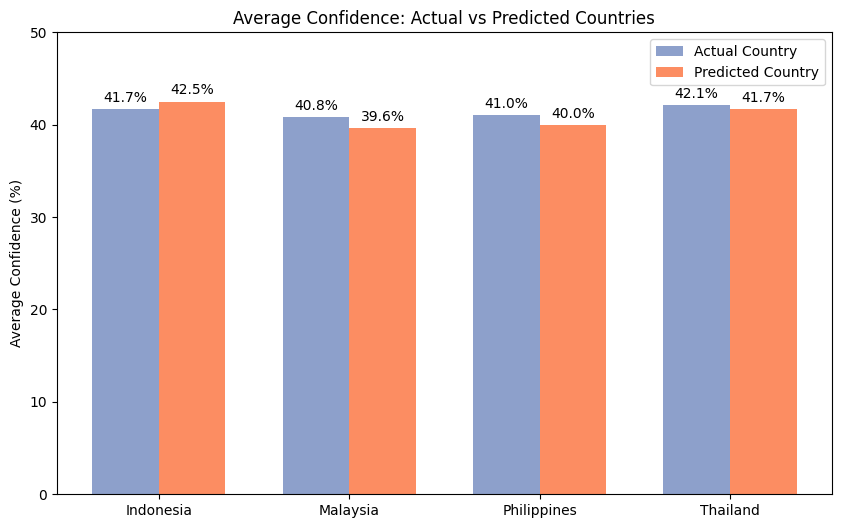

In [43]:
# Comparing both bar graphs

actual_conf = {
    'Indonesia': 41.7,
    'Malaysia': 40.8,
    'Philippines': 41.0,
    'Thailand': 42.1
}

predicted_conf = {
    'Indonesia': 42.5,
    'Malaysia': 39.6,
    'Philippines': 40.0,
    'Thailand': 41.7
}

countries = list(actual_conf.keys())
actual_values = [actual_conf[c] for c in countries]
predicted_values = [predicted_conf[c] for c in countries]

x = np.arange(len(countries))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, actual_values, width, label='Actual Country', color='#8da0cb')
rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted Country', color='#fc8d62')

ax.set_ylabel('Average Confidence (%)')
ax.set_title('Average Confidence: Actual vs Predicted Countries')
ax.set_xticks(x)
ax.set_xticklabels(countries)
ax.set_ylim(0, 50)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

**Insights**

- **Indonesia:**
    - Predicted Confidence (42.5%) is slightly higher than Actual Confidence (41.7%). This suggests the model tends to be a bit more confident when it predicts Indonesia, possibly overestimating its certainty for Indonesia-labeled images.

- **Malaysia:**
    - Actual Confidence (40.8%) is higher than Predicted Confidence (39.6%). The model is slightly more confident when it sees Malaysia images than when it predicts Malaysia, which might suggest it hesitates to label images as Malaysia as often or with high confidence.

- **Philippines:**
    - Both confidences are quite close (41.0% actual vs 40.0% predicted), indicating the model’s confidence is fairly balanced whether it predicts or sees Philippines images.

- **Thailand:**
    - Actual Confidence (42.1%) and Predicted Confidence (41.7%) are also close, showing consistent confidence levels similar to the Philippines.